<a href="https://colab.research.google.com/github/abdulla41mamun/CSE711-SymbolicMachineLearning/blob/main/Lecture3RegForest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

--- Initial Dataset ---
   Age Place of living  IQ-score
0    8         Village         1
1   10            City         3
2   12         Village         1
3   30         Village         4
4   35            City         5
5   60            City         2



==================== STARTING TREE CONSTRUCTION ====================

--- Finding Best Split for Node with 6 Samples ---
Data for this node:
   Age Place of living  IQ-score
0    8         Village         1
1   10            City         3
2   12         Village         1
3   30         Village         4
4   35            City         5
5   60            City         2
------------------------------
Testing split: Age < 9.0
  Left group (avg IQ: 1.00): 1 samples
  Right group (avg IQ: 3.00): 5 samples
  Calculated SSR: 10.0000
Testing split: Age < 11.0
  Left group (avg IQ: 2.00): 2 samples
  Right group (avg IQ: 3.00): 4 samples
  Calculated SSR: 12.0000
Testing split: Age < 21.0
  Left group (avg IQ: 1.67): 3 samples
  Right group

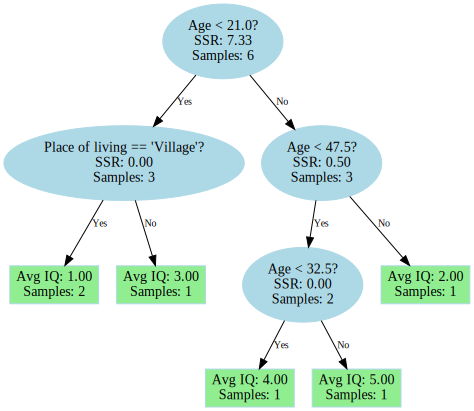

In [2]:
import pandas as pd
import numpy as np
import graphviz

# 1. Create the initial dataset
data = {
    'Age': [8, 10, 12, 30, 35, 60],
    'Place of living': ['Village', 'City', 'Village', 'Village', 'City', 'City'],
    'IQ-score': [1, 3, 1, 4, 5, 2]
}
df = pd.DataFrame(data)

print("--- Initial Dataset ---")
print(df)
print("\n" + "="*50 + "\n")


# 2. Helper function to calculate Sum of Squared Residuals (SSR)
def calculate_ssr(groups, y_name='IQ-score'):
    """Calculates the SSR for a given split."""
    ssr = 0.0
    for group in groups:
        if group.empty:
            continue
        # Calculate the mean of the target variable for the group
        mean_y = group[y_name].mean()
        # Sum the squared differences from the mean
        ssr += ((group[y_name] - mean_y) ** 2).sum()
    return ssr

# 3. Helper function to find the best split for a given dataset
def find_best_split(data, y_name='IQ-score'):
    """
    Iterates through all features and their possible split points,
    calculates SSR for each, and returns the best split found.
    """
    best_ssr = float('inf')
    best_split = {}

    features = [col for col in data.columns if col != y_name]

    print(f"\n--- Finding Best Split for Node with {len(data)} Samples ---")
    print("Data for this node:")
    print(data.to_string())
    print("-" * 30)

    for feature in features:
        # For numerical features
        if pd.api.types.is_numeric_dtype(data[feature]):
            # Sort unique values to find midpoints
            unique_values = sorted(data[feature].unique())
            for i in range(len(unique_values) - 1):
                split_value = (unique_values[i] + unique_values[i+1]) / 2

                # Split data
                left_group = data[data[feature] < split_value]
                right_group = data[data[feature] >= split_value]

                ssr = calculate_ssr([left_group, right_group], y_name)

                print(f"Testing split: {feature} < {split_value}")
                print(f"  Left group (avg IQ: {left_group[y_name].mean():.2f}): {len(left_group)} samples")
                print(f"  Right group (avg IQ: {right_group[y_name].mean():.2f}): {len(right_group)} samples")
                print(f"  Calculated SSR: {ssr:.4f}")

                if ssr < best_ssr:
                    best_ssr = ssr
                    best_split = {
                        'feature': feature,
                        'value': split_value,
                        'ssr': ssr,
                        'groups': (left_group, right_group)
                    }
        # For categorical features
        else:
            unique_values = data[feature].unique()
            # We only need to test one value for a binary split
            if len(unique_values) > 1:
                value = unique_values[0]
                # Split data
                left_group = data[data[feature] == value]
                right_group = data[data[feature] != value]

                ssr = calculate_ssr([left_group, right_group], y_name)

                print(f"Testing split: {feature} == '{value}'")
                print(f"  Left group (avg IQ: {left_group[y_name].mean():.2f}): {len(left_group)} samples")
                print(f"  Right group (avg IQ: {right_group[y_name].mean():.2f}): {len(right_group)} samples")
                print(f"  Calculated SSR: {ssr:.4f}")

                if ssr < best_ssr:
                    best_ssr = ssr
                    best_split = {
                        'feature': feature,
                        'value': value,
                        'ssr': ssr,
                        'groups': (left_group, right_group)
                    }

    print(f"\n>>> Best split for this node: '{best_split.get('feature')}' with value '{best_split.get('value')}' (SSR: {best_split.get('ssr', float('inf')):.4f})")
    return best_split

# 4. Recursive function to build the tree
def build_tree(data, dot, parent_id=None, edge_label="", max_depth=3, depth=0, node_id=[0]):
    """Recursively builds the tree and adds nodes/edges to the graphviz object."""

    current_id = str(node_id[0])
    node_id[0] += 1

    # Base case for recursion: if no data, or pure node, or max depth
    if data.empty or len(data['IQ-score'].unique()) == 1 or depth >= max_depth:
        leaf_value = data['IQ-score'].mean() if not data.empty else 0
        dot.node(current_id, f"Avg IQ: {leaf_value:.2f}\nSamples: {len(data)}", shape='box', style='filled', fillcolor='lightgreen')
        if parent_id:
            dot.edge(parent_id, current_id, label=edge_label)
        return

    split = find_best_split(data)

    # Another stopping condition: if a split doesn't reduce SSR or is invalid
    if not split or split['ssr'] == float('inf'):
        leaf_value = data['IQ-score'].mean()
        dot.node(current_id, f"Avg IQ: {leaf_value:.2f}\nSamples: {len(data)}", shape='box', style='filled', fillcolor='lightgreen')
        if parent_id:
            dot.edge(parent_id, current_id, label=edge_label)
        return

    feature, value = split['feature'], split['value']

    if isinstance(value, str):
        question = f"{feature} == '{value}'?"
        yes_label, no_label = "Yes", "No"
    else:
        question = f"{feature} < {value}?"
        yes_label, no_label = "Yes", "No"

    dot.node(current_id, f"{question}\nSSR: {split['ssr']:.2f}\nSamples: {len(data)}", shape='ellipse', style='filled', fillcolor='lightblue')

    if parent_id:
        dot.edge(parent_id, current_id, label=edge_label)

    left_group, right_group = split['groups']

    print("\n" + "="*20 + f" Recursing on LEFT ('Yes') branch (Depth: {depth+1}) " + "="*20)
    build_tree(left_group, dot, current_id, yes_label, max_depth, depth + 1, node_id)

    print("\n" + "="*20 + f" Recursing on RIGHT ('No') branch (Depth: {depth+1}) " + "="*20)
    build_tree(right_group, dot, current_id, no_label, max_depth, depth + 1, node_id)


# 5. Main execution block
dot = graphviz.Digraph('RegressionTree', comment='Regression Tree from Scratch')
dot.attr(rankdir='TB', size='8,8')
dot.attr('node', shape='ellipse', style='filled', color='lightblue')
dot.attr('edge', fontsize='10')

print("\n" + "="*20 + " STARTING TREE CONSTRUCTION " + "="*20)
build_tree(df, dot, max_depth=3)
print("\n" + "="*20 + " FINISHED TREE CONSTRUCTION " + "="*20 + "\n")

print("--- Final Regression Tree ---")
# In Google Colab, returning the 'dot' object at the end of a cell will display the graph automatically.
dot
